In [86]:
DATASETS = ['LGI_PPGI', 'MR_NIRP', 'UBFC_PHYS']

In [2]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
from pyVHR.analysis.pipelineLandmarks import *
import constants
import pandas as pd
import numpy as np
import analyze

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
vhr.plot.VisualizeParams.renderer = 'vscode' 

from scipy.stats import f_oneway
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
from statsmodels.stats.multicomp import pairwise_tukeyhsd

plt.rcParams.fontsize = 14
import matplotlib.ticker as ticker

all_landmarks_names = list(CustomLandmarks().get_all_landmarks().keys())

PALETTE = 'Spectral' # "Spectral"
ROIS = ['forehead', 'nose', 'cheeks','mustache', 'temple','jaw']
SETTINGS = analyze.get_dataset_settings(DATASETS)

C:\Users\erolland\AppData\Roaming\Python\Python39\site-packages\cupy\_environment.py:487: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
c:\Users\erolland\.conda\envs\project\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to l

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Video settings in LGI_PPGI:  dict_keys(['GYM', 'STILL', 'ROTATION', 'TALK', 'MALE', 'FEMALE', 'BEARD', 'GLASSES'])
Video settings in MR_NIRP:  dict_keys(['MOTION', 'STILL', 'MALE', 'FEMALE', 'BEARD', 'DARK'])
Video settings in UBFC_PHYS:  dict_keys(['STILL', 'MALE', 'FEMALE', 'GLASSES', 'BEARD', 'DARK', 'BANG'])


In [3]:
# Top landmarks: Landmarks considered in combinations
top_ldmks = ['glabella', 'upper_nasal_dorsum', 'lower_medial_forehead', 'soft_triangle', 'malar', 'lower_lateral_forehead', 'chin', 'lower_cheek', 'ala', 'nasolabial_fold', 'marionette_fold']
print(len(top_ldmks), top_ldmks)

# top_ldmks_sym : landmarks with left and right component as separate
ldmk_names_dict = {ldmk.replace('left_', '').replace('right_', ''): ldmk for ldmk in all_landmarks_names} # name without left right: name with right
top_ldmks_sym = [ldmk_names_dict[ldmk] for ldmk in top_ldmks]
for ldmk in top_ldmks_sym:
    if 'right_' in ldmk:
        top_ldmks_sym.append(ldmk.replace('right', 'left'))
print(len(top_ldmks_sym), top_ldmks_sym)

# Mapping between landmarks and their respective ID number
ldmk_mapping = {'lower_medial_forehead':'1', 'glabella':'2', 'lower_lateral_forehead':'3, 4',  'temporal':'5, 6', 'upper_nasal_dorsum':'7', 'lower_nasal_dorsum':'8',
 'mid_nasal_sidewall':'9, 10',  'lower_nasal_sidewall':'11, 12', 'nasal_tip':'13', 'soft_triangle':'14', 'ala':'15, 16',
  'nasolabial_fold':'17, 18', 'upper_lip':'19, 20', 'malar':'21, 22', 'philtrum':'23', 'lower_cheek':'24, 25', 'marionette_fold':'26, 27', 'chin':'28'}

11 ['glabella', 'upper_nasal_dorsum', 'lower_medial_forehead', 'soft_triangle', 'malar', 'lower_lateral_forehead', 'chin', 'lower_cheek', 'ala', 'nasolabial_fold', 'marionette_fold']
17 ['glabella', 'upper_nasal_dorsum', 'lower_medial_forehead', 'soft_triangle', 'right_malar', 'right_lower_lateral_forehead', 'chin', 'right_lower_cheek', 'right_ala', 'right_nasolabial_fold', 'right_marionette_fold', 'left_malar', 'left_lower_lateral_forehead', 'left_lower_cheek', 'left_ala', 'left_nasolabial_fold', 'left_marionette_fold']


In [4]:
def get_still(df):
    """
    Only select still videos in the dataset
    """

    df = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | 
            (df['dataset'] == 'mr_nirp') & df['videoFilename'].str.contains('still') | 
            (df['dataset'] == 'ubfc_phys')].copy().reset_index(drop=True)
    
    return df

def get_motion(df):
    """
    Only select motion videos in the dataset
    """
    df = df[(df['dataset'] == 'lgi_ppgi') &  ~df['videoFilename'].str.contains('resting')].copy().reset_index(drop=True)
    
    return df

# Individual landmarks

- Plot average MAE for individual landmarks.
- Colors are organized by ROI and landmarks
- 18 landmarks (symmetric as one)

In [144]:
df = pd.DataFrame()
for dataset_name in DATASETS:
    df = pd.concat([df, pd.read_hdf(f'../result/{dataset_name}/{dataset_name}_18.h5')])
df = df.query("method == 'cupy_CHROM'") 
df = analyze.format_data(df)
df = analyze.format_data_symmetric_landmark(df, symmetric=True) 
df['landmarks_id'] = df['landmarks'].apply(lambda x: ldmk_mapping[x])

print(df.shape, "Face Regions: ", df.region.unique(), df.region.unique().size)
print("Landmarks: ", df.landmarks.unique().size)
df.head(1)

(1332, 18) Face Regions:  ['jaw' 'forehead' 'nose' 'cheeks' 'mustache' 'temple'] 6
Landmarks:  18


,dataset,videoFilename,videoIdx,landmarks,RMSE,MAE,PCC,SNR,rPPG_PCC,DTW,bpmGT,bpmES,timeGT,timeES,sampling,region,OS,landmarks_id
0,lgi_ppgi,alex_gym,0,chin,39.10903,32.318034,0.223853,-4.976998,0.034377,2.601803,"[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[43.9453125, 158.203125, 60.791015625, 108.398...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]",random_10_10,jaw,0.502273,28


## Still faces

Still videos:  56 videos


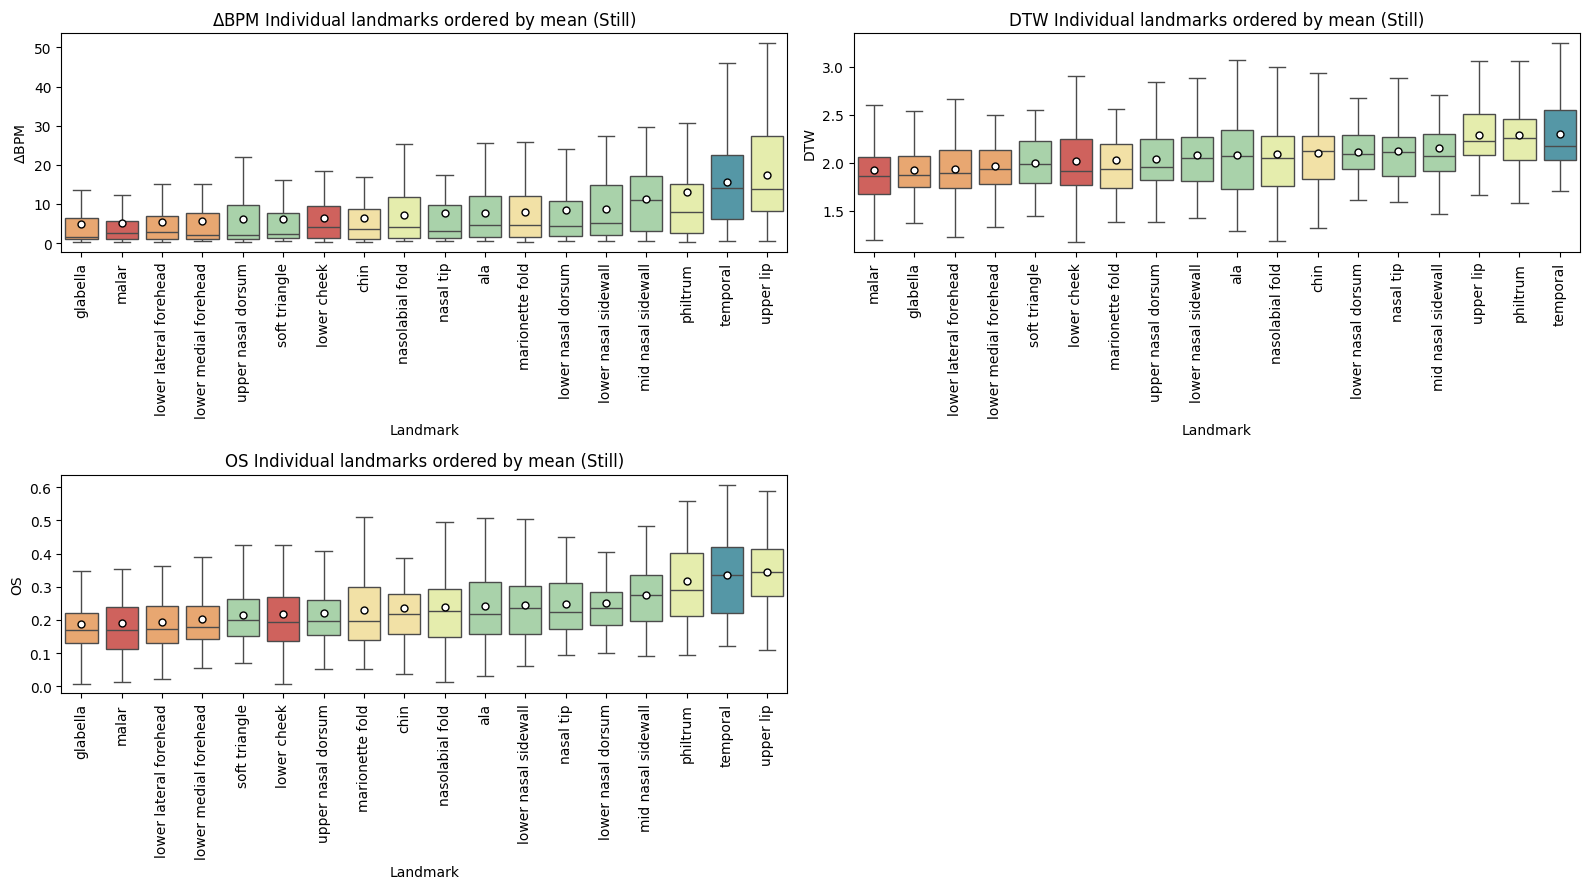

In [145]:
x = get_still(df)
print("Still videos: ", x.videoFilename.unique().size, 'videos')
setting_name = 'Still'

fig, axs = plt.subplots(2,2, figsize=(16,9))
grouped, box = analyze.plot_boxplot_each_landmark(x, 'MAE', 'landmarks', setting_name, ax=axs[0,0])
grouped, box = analyze.plot_boxplot_each_landmark(x, 'DTW', 'landmarks', setting_name, ax=axs[0,1])
grouped, box = analyze.plot_boxplot_each_landmark(x, 'OS', 'landmarks', setting_name, ax=axs[1,0])
axs[1,1].axis('off')
fig.tight_layout()

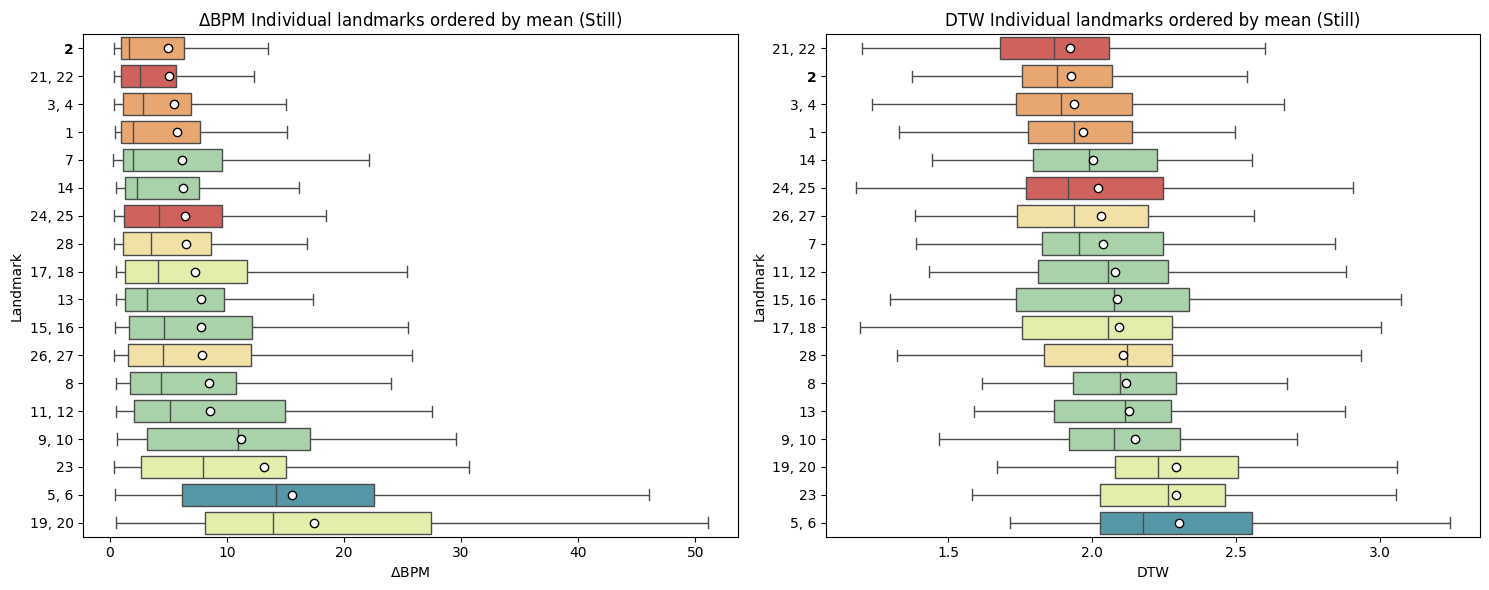

In [7]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
grouped, box = analyze.plot_boxplot_each_landmark(x, 'MAE', 'landmarks_id', setting_name, ax=axs[0])
grouped, box = analyze.plot_boxplot_each_landmark(x, 'DTW', 'landmarks_id', setting_name, ax=axs[1])
fig.tight_layout()

In [142]:
y, df_rank, ldmk_score_dict = analyze.get_df_rank(x)
display(df_rank.head(1))

,landmarks_id,landmarks,region,MAE_median,MAE_mean,MAE_std,OS_median,OS_mean,OS_std,DTW_median,DTW_mean,DTW_std,rank_MAE,rank_DTW,rank_OS,bin
0,2,glabella,forehead,1.617733,4.937024,6.512763,0.16858,0.18892,0.090204,1.876081,1.924536,0.319861,1,2,1,G1: < 0.1%


## Motion

Motion videos:  18 videos


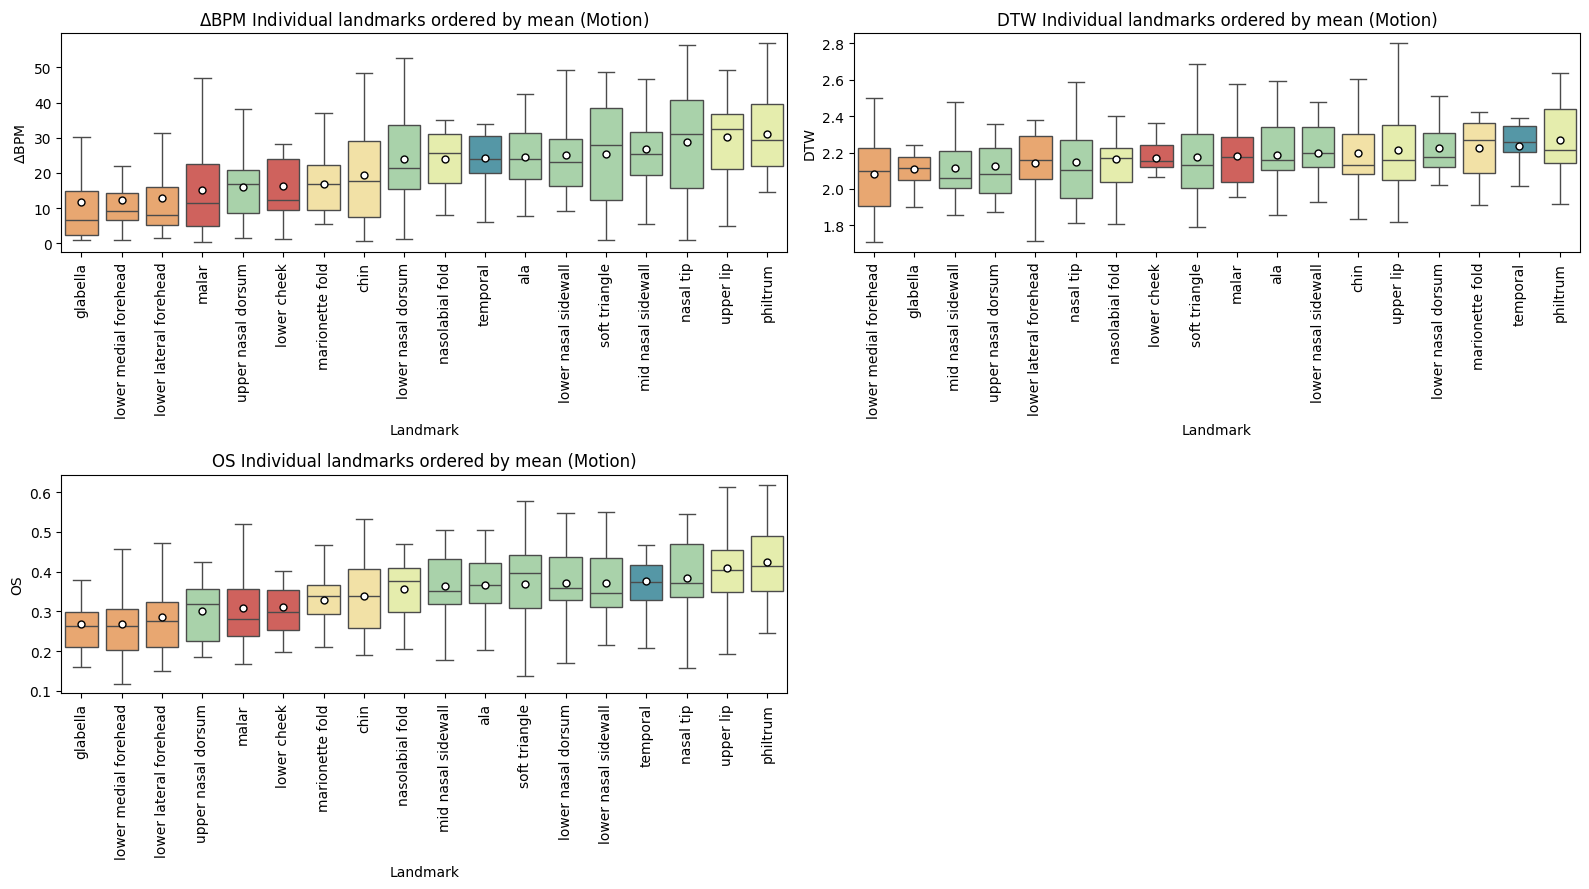

In [ ]:
x = get_motion(df)
print("Motion videos: ", x.videoFilename.unique().size, 'videos')
setting_name = 'Motion'

fig, axs = plt.subplots(2,2, figsize=(16,9))
grouped, box = analyze.plot_boxplot_each_landmark(x, 'MAE', 'landmarks', setting_name, ax=axs[0,0])
grouped, box = analyze.plot_boxplot_each_landmark(x, 'DTW', 'landmarks', setting_name, ax=axs[0,1])
grouped, box = analyze.plot_boxplot_each_landmark(x, 'OS', 'landmarks', setting_name, ax=axs[1,0])
axs[1,1].axis('off')
fig.tight_layout()

In [ ]:
y, df_rank, ldmk_score_dict = analyze.get_df_rank(x)
display(df_rank.head(1))

,landmarks_id,landmarks,region,MAE_median,MAE_mean,MAE_std,OS_median,OS_mean,OS_std,DTW_median,DTW_mean,DTW_std,rank_MAE,rank_DTW,rank_OS,bin
0,2,glabella,forehead,6.552083,11.641168,12.997439,0.263,0.269114,0.076884,2.117133,2.106752,0.146816,1,2,1,G1: < 0.1%


## Statistical Tests

In [110]:
x = get_still(df)
x['landmarks'] = x['landmarks'].apply(lambda x: x.replace('_', ' '))
groups = [x[x['landmarks'] == landmark]['MAE'] for landmark in x['landmarks'].unique()]
_, _, ldmk_score_dict = analyze.get_df_rank(x)

# ANOVA on landmarks
anova = f_oneway(*groups)
print("ANOVA p-value: ", anova.pvalue)
print("Reject null hypothesis: ", anova.pvalue < 0.05, ". If True, then at least one landmark is significantly different from the others")

# Tukey HSD post-hoc analysis
tukey_results = pairwise_tukeyhsd(x['MAE'], x['landmarks'], 0.05)
tukey_results._simultaneous_ci()

ANOVA p-value:  1.2933439740169085e-20
Reject null hypothesis:  True . If True, then at least one landmark is significantly different from the others


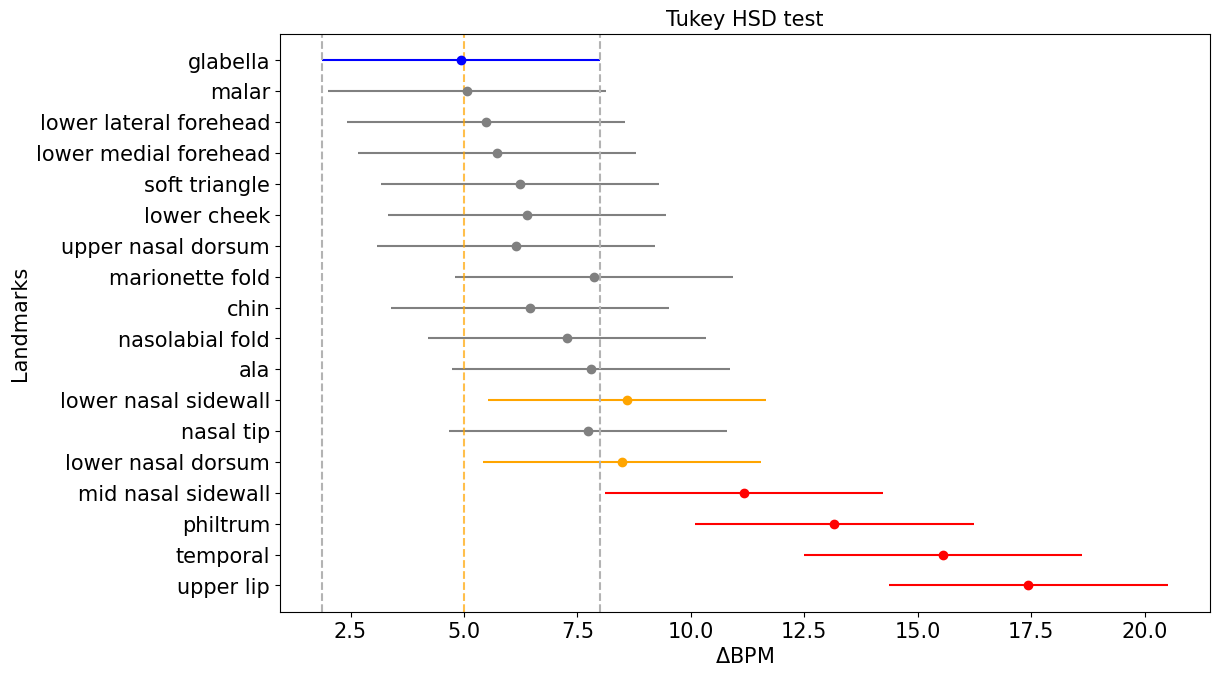

In [111]:
fig, ax = plt.subplots(1,1,figsize=(12,7.5))
ax = analyze.plot_tukey_results(tukey_results, ldmk_score_dict, 'glabella', True, ax)
plt.show()

ANOVA p-value:  4.606922104353488e-09
Reject null hypothesis:  True . If True, then at least one landmark is significantly different from the others


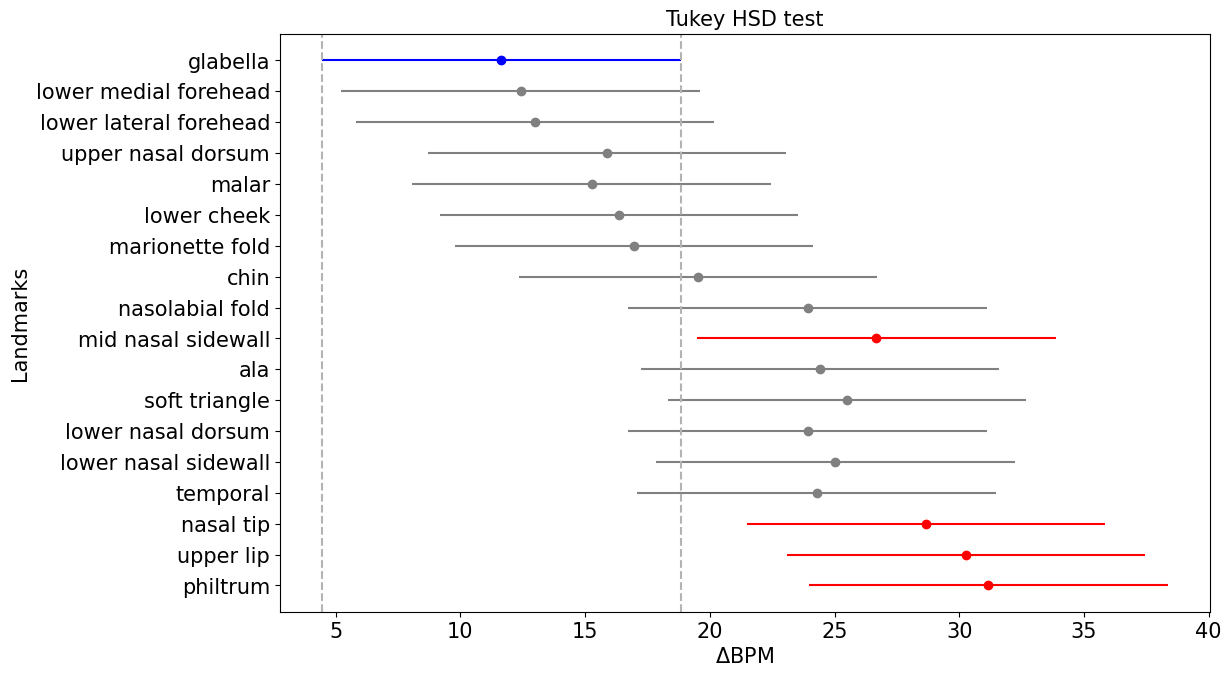

In [112]:
x = get_motion(df)
x['landmarks'] = x['landmarks'].apply(lambda x: x.replace('_', ' '))
groups = [x[x['landmarks'] == landmark]['MAE'] for landmark in x['landmarks'].unique()]
_, _, ldmk_score_dict = analyze.get_df_rank(x)

# ANOVA on landmarks
anova = f_oneway(*groups)
print("ANOVA p-value: ", anova.pvalue)
print("Reject null hypothesis: ", anova.pvalue < 0.05, ". If True, then at least one landmark is significantly different from the others")

# Tukey HSD post-hoc analysis
tukey_results = pairwise_tukeyhsd(x['MAE'], x['landmarks'], 0.05)
tukey_results._simultaneous_ci()

# Figure for Tuckey HSD 
fig, ax = plt.subplots(1,1,figsize=(12,7.5))
ax = analyze.plot_tukey_results(tukey_results, ldmk_score_dict, 'glabella', False, ax)
plt.show()

## ROI Occlusion

In [188]:
x = get_still(df)

In [220]:
# Statistical tests

def test_setting(setting, x):
    tests = pd.DataFrame()
    if setting == 'BEARD':
        ldmks_setting = ['chin', 'lower_cheek', 'marionette_fold', 'upper_lip', 'philtrum', 'nasolabial_fold']
    elif setting == 'BANG':
        ldmks_setting = ['glabella', 'upper_nasal_dorsum', 'lower_lateral_forehead', 'lower_medial_forehead']
    elif setting == 'DARK':
        ldmks_setting = x.landmarks.unique()
    elif setting == 'GLASSES':
        ldmks_setting = ['malar', 'mid_nasal_sidewall',  'lower_nasal_dorsum', 'upper_nasal_dorsum', 'temporal']

    for landmarks in ldmks_setting:
        tests = pd.concat([tests, analyze.test_pvalue(x[x['landmarks'].apply(lambda x: landmarks in x)].copy(), setting, SETTINGS, condition=landmarks, kruskal=True)])
    print('------------- SETTING: ', setting)
    display(tests[~tests[['ttest_pvalue_significant','ttest_less_significant', 'Kruskal_pvalue_significant']].eq(False).all(axis=1)])

    return tests

tests1 = test_setting('BEARD', x)
tests2 = test_setting('BANG', x)
tests3 = test_setting('GLASSES', x)

------------- SETTING:  BEARD


,Setting,Condition,Metric,ttest_stat,ttest_pvalue,ttest_less,Kruskal_stat,Kruskal_pvalue,ttest_pvalue_significant,ttest_less_significant,Kruskal_pvalue_significant
0,BEARD,upper_lip,MAE,-4.408426,0.000,0.000,13.062600,0.000,True,True,True
0,BEARD,philtrum,MAE,-2.817664,0.015,0.008,11.795853,0.001,True,True,True


------------- SETTING:  BANG


,Setting,Condition,Metric,ttest_stat,ttest_pvalue,ttest_less,Kruskal_stat,Kruskal_pvalue,ttest_pvalue_significant,ttest_less_significant,Kruskal_pvalue_significant
0,BANG,lower_lateral_forehead,MAE,-2.109725,0.076,None,4.916526,0.027,False,False,True
0,BANG,lower_medial_forehead,MAE,-2.192166,0.069,None,4.699248,0.030,False,False,True


------------- SETTING:  GLASSES


,Setting,Condition,Metric,ttest_stat,ttest_pvalue,ttest_less,Kruskal_stat,Kruskal_pvalue,ttest_pvalue_significant,ttest_less_significant,Kruskal_pvalue_significant
0,GLASSES,malar,MAE,-1.507022,0.158,None,3.960553,0.047,False,False,True
0,GLASSES,upper_nasal_dorsum,MAE,-1.897790,0.082,None,5.193089,0.023,False,False,True
0,GLASSES,temporal,MAE,-1.940431,0.066,None,3.960553,0.047,False,False,True


Motion videos:  18 videos


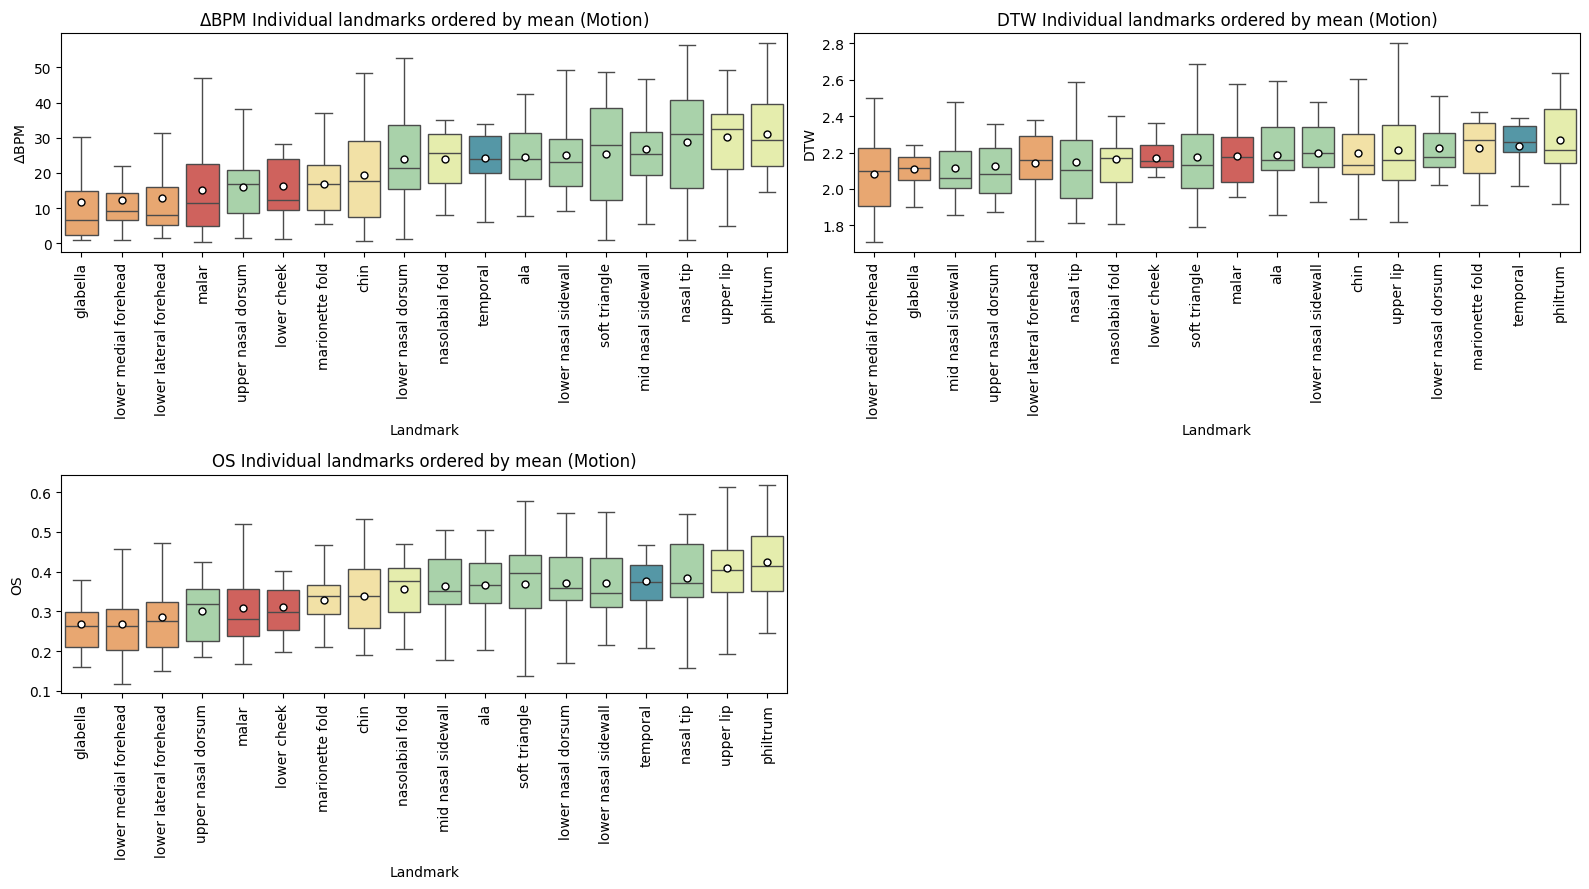

In [29]:
x = get_motion(df)
print("Motion videos: ", x.videoFilename.unique().size, 'videos')
setting_name = 'Motion'

fig, axs = plt.subplots(2,2, figsize=(16,9))
grouped, box = analyze.plot_boxplot_each_landmark(x, 'MAE', 'landmarks', setting_name, ax=axs[0,0])
grouped, box = analyze.plot_boxplot_each_landmark(x, 'DTW', 'landmarks', setting_name, ax=axs[0,1])
grouped, box = analyze.plot_boxplot_each_landmark(x, 'OS', 'landmarks', setting_name, ax=axs[1,0])
axs[1,1].axis('off')
fig.tight_layout()

In [70]:
y, df_rank, ldmk_score_dict = analyze.get_df_rank(x)
display(df_rank.head(1))

,landmarks_id,landmarks,region,MAE_median,MAE_mean,MAE_std,OS_median,OS_mean,OS_std,DTW_median,DTW_mean,DTW_std,rank_MAE,rank_DTW,rank_OS,bin
0,2,glabella,forehead,6.552083,11.641168,12.997439,0.263,0.269114,0.076884,2.117133,2.106752,0.146816,1,2,1,G1: < 0.1%


# Combinations

In [42]:
df = pd.DataFrame()
for dataset_name in DATASETS:
    df = pd.concat([df, pd.read_hdf(f'../result/{dataset_name}/{dataset_name}_18.h5')])
for dataset_name in DATASETS:
    df = pd.concat([df, pd.read_hdf(f'../result/{dataset_name}/{dataset_name}_combine.h5')])
df = df[~df['landmarks'].apply(lambda x: 'nasal_tip' in x)].reset_index(drop=True)
df['landmarks'] = df['landmarks'].apply(lambda x: tuple(sorted(x)))
df = analyze.format_data(df.drop_duplicates(['videoFilename', 'landmarks'])).reset_index(drop=True).drop(columns=['bpmGT', 'bpmES', 'timeGT', 'timeES',])

# Format new columns
df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
df['landmarks_names'] = df['landmarks'].apply(lambda x: set([name.replace('left_', '').replace('right_', '').replace('_', ' ').strip() for name in x]))
df['landmarks_len'] = df['landmarks_names'].apply(lambda x: len(x))
df['region'] = df['region'].apply(lambda x: '_'.join(sorted(x.split('_')))) # Sort face regions 
df['region'] = df['region'].apply(lambda x: ', '.join([roi[0].upper() for roi in x.split('_')]))

# Only consider combinations up to 5 elements
df = df.query('landmarks_len <= 5').reset_index(drop=True)

print(f"{df.videoFilename.unique().size} videos, {df.landmarks.unique().size} landmarks, {df.shape}")
print("Number of different landmarks combination", df.landmarks_id.unique().size)
df.head(1)

74 videos, 1029 landmarks, (76146, 16)
Number of different landmarks combination 1029


,dataset,videoFilename,videoIdx,landmarks,RMSE,MAE,PCC,SNR,rPPG_PCC,DTW,sampling,region,OS,landmarks_id,landmarks_names,landmarks_len
0,lgi_ppgi,alex_gym,0,"(chin,)",39.10903,32.318034,0.223853,-4.976998,0.034377,2.601803,random_10_10,J,0.485781,0,{chin},1


In [34]:
# all individual landmarks
df_ind_all = pd.DataFrame()
for dataset_name in DATASETS:
    df_ind_all = pd.concat([df_ind_all, pd.read_hdf(f'../result/{dataset_name}/{dataset_name}_18.h5')])
df_ind_all = df_ind_all.query('method == "cupy_CHROM"').reset_index(drop=True).copy()
df_ind_all = analyze.format_data(df_ind_all)
df_ind_all['landmarks_id'] = df_ind_all['landmarks'].astype('category').cat.codes
df_ind_all.head(1)

,dataset,videoFilename,videoIdx,landmarks,RMSE,MAE,PCC,SNR,rPPG_PCC,DTW,bpmGT,bpmES,timeGT,timeES,sampling,region,OS,landmarks_id
0,lgi_ppgi,alex_gym,0,"(chin,)",39.10903,32.318034,0.223853,-4.976998,0.034377,2.601803,"[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[43.9453125, 158.203125, 60.791015625, 108.398...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]",random_10_10,jaw,0.502273,0


## Still faces

In [35]:
x = get_still(df)
_, df_rank, ldmk_score_dict = analyze.get_df_rank(x.query('landmarks_len > 1'), bins=[0,0.1,0.9, 1])
df_rank = df_rank.sort_values('MAE_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

_, df_ind, _ = analyze.get_df_rank(x.query('landmarks_len == 1'), bins=[0,0.1,0.9, 1])
df_ind = df_ind.sort_values('MAE_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

Compare individual landmarks to combinations

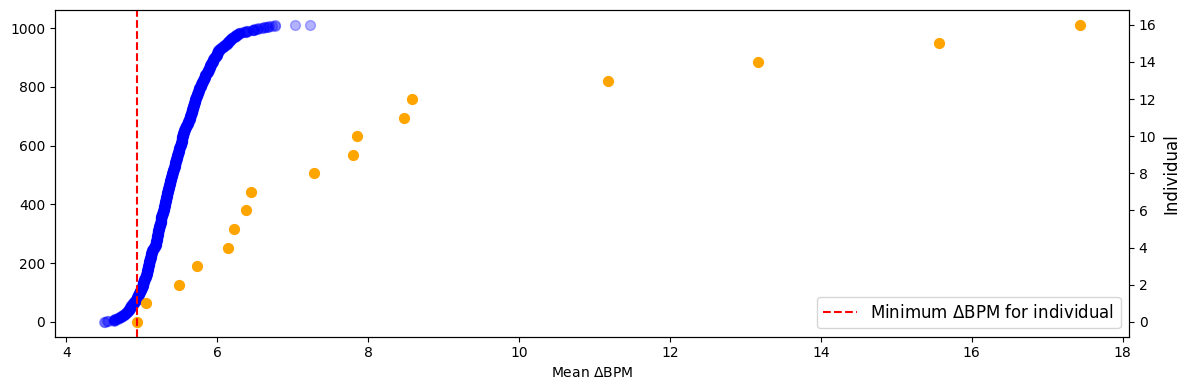

In [36]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(1,1,figsize=(12,4), sharey=True)
ax2 = ax1.twinx()
df_rank = df_rank.sort_values('MAE_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

# plot the same data on both axes
ax1.scatter(y=df_rank['landmarks_id'], x=df_rank['MAE_mean'], s=50, c='blue', alpha=0.3, label='Combination of landmarks')
ax2.scatter(y=df_ind['landmarks_id'], x=df_ind['MAE_mean'], s=50, c='orange')
ax2.set_ylabel('Individual', fontsize=12)


ax2.axvline(df_ind['MAE_mean'].min(), color='red', linestyle='--', label=r'Minimum $\Delta$BPM for individual')
# fig.legend(fontsize=11,bbox_to_anchor=[0.92, 0.25],loc='lower right')
plt.legend(fontsize=12)
ax1.set_xlabel(r'Mean $\Delta$BPM')
fig.tight_layout()
plt.show()

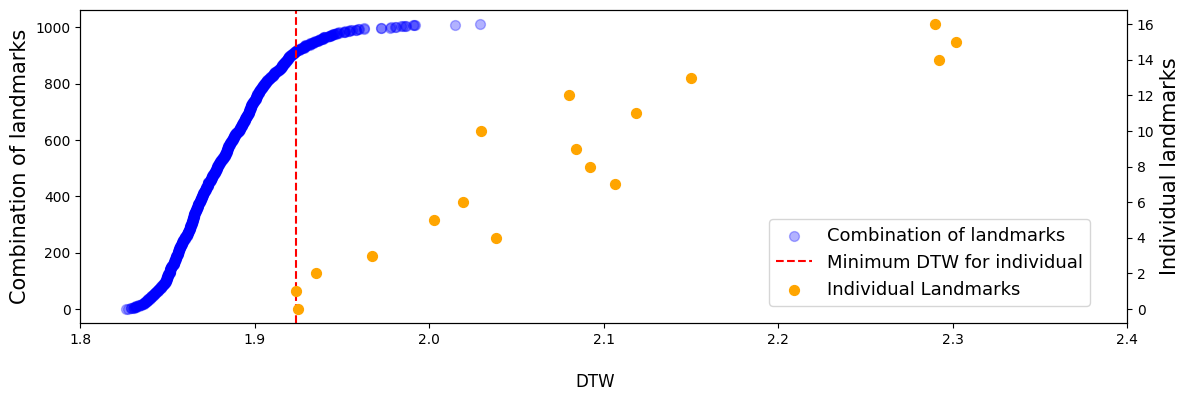

In [37]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(1,1,figsize=(12,4), sharey=True)
ax2 = ax1.twinx()
df_rank = df_rank.sort_values('DTW_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

# plot the same data on both axes
ax1.scatter(y=df_rank['landmarks_id'], x=df_rank['DTW_mean'], s=50, c='blue', alpha=0.3, label='Combination of landmarks')
ax2.scatter(y=df_ind['landmarks_id'], x=df_ind['DTW_mean'], s=50, c='orange', label='Individual Landmarks')
ax1.set_ylabel('Combination of landmarks', fontsize=15)
ax2.set_ylabel('Individual landmarks', fontsize=15)

ax1.set_xlim(1.8,2.4) 
ax2.set_xlim(1.8,2.4) 

ax1.axvline(df_ind['DTW_mean'].min(), color='red', linestyle='--', label=r'Minimum DTW for individual')
fig.legend(fontsize=13,bbox_to_anchor=[0.92, 0.2],loc='lower right')
fig.supxlabel(r'DTW')
fig.tight_layout()
plt.show()

Inspect top combinations

In [39]:
x = get_still(df)
_, df_rank_still, ldmk_score_dict = analyze.get_df_rank(x.query('landmarks_len > 1'), bins=[0,0.1,0.9, 1])

df_ind = get_still(df_ind_all)
_, df_ind, _ = analyze.get_df_rank(df_ind, bins=[0,0.1,0.9, 1])
df_ind = df_ind.sort_values('MAE_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

G1_still = df_rank_still.query(f'MAE_mean < {df_ind.MAE_mean.min()}').landmarks_id.unique()

print("Landmarks with MAE mean < individual: ",len(df_rank_still.query(f'MAE_mean < {df_ind.MAE_mean.min()}')))
print("Landmarks with DTW mean < individual: ",len(df_rank_still.query(f'DTW_mean < {df_ind.DTW_mean.min()}')))
print("Landmakrs in G1: ", len(G1_still) )

df_rank_still = df_rank_still.sort_values('MAE_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

Landmarks with MAE mean < individual:  81
Landmarks with DTW mean < individual:  916
Landmakrs in G1:  81


In [51]:
x = get_still(df)

# Mean MAE < 5
y = x.groupby(['landmarks_id', ])['MAE'].agg(['median','mean','std']).sort_values(by='mean', ascending=True).query('mean < 5').reset_index()
print("Number of combinations with mean MAE < 5: ", len(y.landmarks_id.unique()))

# G1: Mean MAE < best individual landmark
x_still= x[x['landmarks_id'].isin(G1_still)]

# From the combinations with mean MAE < 5, divide into bins wrt quantiles
x_all, df_rank, ldmk_OS_dict = analyze.get_df_rank(x_still, bins=[0,0.1,0.9, 1])
df_top = df_rank.iloc[:10].copy()
df_top = df_top.merge(df[['landmarks_id', 'landmarks_names', 'landmarks_len']].drop_duplicates('landmarks_id'), on='landmarks_id', how='left')

display(df_top.head(1)) 

Number of combinations with mean MAE < 5:  120


,landmarks_id,landmarks,region,MAE_median,MAE_mean,MAE_std,OS_median,OS_mean,OS_std,DTW_median,DTW_mean,DTW_std,rank_MAE,rank_DTW,rank_OS,bin,landmarks_names,landmarks_len
0,554,"(glabella, left_lower_lateral_forehead, left_m...","C, F, N",1.941201,4.882743,5.674807,0.159283,0.173159,0.08775,1.811871,1.831645,0.346708,62,1,1,G2: 0.1-0.9%,"{lower lateral forehead, glabella, soft triang...",5


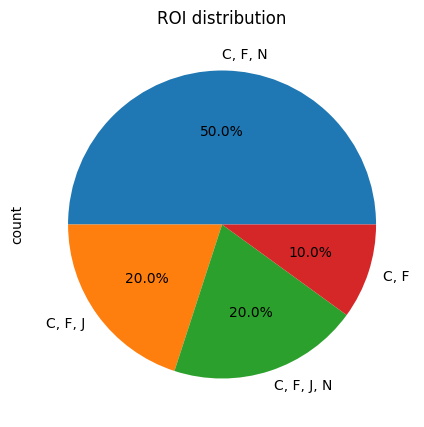

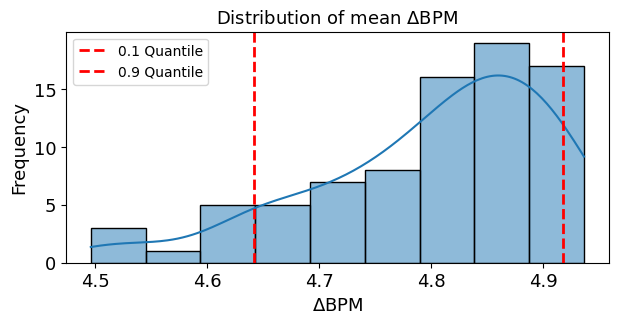

In [50]:
# EDA Plots 

fig, ax = plt.subplots(1,1, figsize=(5,5))
df_top['region'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
ax.set_title('Face Regions distribution')
plt.show()

# Create the histogram plot
quantiles = [0.1,0.9]
fig,ax = plt.subplots(1,1, figsize=(7, 3))
ax.tick_params(axis='both', which='major', labelsize=13)
sns.histplot(df_rank['MAE_mean'], kde=True, ax=ax, bins=9)
for quantile in quantiles:
    ax.axvline(df_rank['MAE_mean'].quantile(quantile), linestyle='dashed', color='red', linewidth=2, label=f'{quantile} Quantile')
ax.set_xlabel(r'$\Delta$BPM', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13)
ax.set_title(r'Distribution of mean $\Delta$BPM', fontsize=13)
ax.legend()


In [ ]:
sym_ldmks = ['glabella', 'lower_lateral_forehead', 'malar', 'lower_medial_forehead', 'soft_triangle', 'upper_nasal_dorsum', 'marionette_fold', 'chin', 'lower_cheek', 'nasolabial_fold', 'ala']

# Mean MAE < 5
y = x.groupby(['landmarks_id', ])['MAE'].agg(['median','mean','std']).sort_values(by='mean', ascending=True).query('mean < 5').reset_index()
print("Number of combinations with mean MAE < 5: ", len(y.landmarks_id.unique()))
x = x[x['landmarks_id'].isin(G1_still)]
x_all, df_rank, ldmk_OS_dict = analyze.get_df_rank(x, bins=[0,0.1,0.9, 1])
df_rank = df_rank.merge(df[['landmarks_id', 'landmarks_names', 'landmarks_len']].drop_duplicates('landmarks_id'), on='landmarks_id', how='left')
df_rank['landmarks_names'] = df_rank['landmarks_names'].apply(lambda x: ', '.join(map(str, sorted(x))).replace('_', ' '))
tmp = df_rank.iloc[:10].copy()
# tmp = df_rank


In [ ]:
def agg_ldmk_comb(y, agg_col, case='ind_ldmk'):
    df_ldmk = df[agg_col].drop_duplicadf_ldmkes().sordf_ldmk_values(by=0, axis=1, ascending=False).copy().df_ldmk.resedf_ldmk_index().rename({0: 'Frequency Disdf_ldmkribudf_ldmkion', 'index':'Landmarks'}, axis=1)
    if case == 'ind_ldmk':
        rois = pyVHR.exdf_ldmkracdf_ldmkion.Cusdf_ldmkomLandmarks().gedf_ldmk_face_regions()
        for roi in lisdf_ldmk(rois.keys()):
            rois[roi] = [name.replace('lefdf_ldmk_', '').replace('righdf_ldmk_', '') for name in rois[roi]]
            df_ldmk.loc[df_ldmk['Landmarks'].isin(rois[f'{roi}']),'ROI'] = roi    
        df_ldmk['Landmarks'] = df_ldmk['Landmarks'].apply(lambda x: x.replace('_', ' '))
    if case == 'comb_ldmk':
        df_ldmk['ROI'] = df_ldmk['Landmarks'].apply(lambda x: ', '.join([roi[0].upper() for roi in x.splidf_ldmk('_')]))

    redf_ldmkurn df_ldmk

In [ ]:
def  eda_landmarks(df, setting=['Still'], ldmks=None):

    for ldmk in ldmks:
        df[ldmk] = df['landmarks_names'].apply(lambda x: ldmk.replace('_', ' ') in x.split(', ')).sum() / df.shape[0]

df_still = eda_landmarks(x_still)

t1 = analyze_comb.agg_ldmk_comb(df, ldmks,case='ind_ldmk')
t1['setting'] = 'Still'
t_ldmk = analyze_comb.freq_ldmk_comb([t1], col='Landmarks', hue_col='setting', figsize=(10,6)) 

Overall: Mean value for OS going from 0.16639117190876013 to 0.1871084512520841
Top 2 landmarks (10%) from 27 landmarks
0 \%  & 0 \%  & 0 \%  & 0 \%  & 50 \%  & 50 \%  & Mean value for OS going from 0.16639117190876013 to 0.1678459693244955


,forehead,nose,cheeks,jaw,temple,mustache
0,0.0,0.0,0.0,0.0,0.0,0.0


,"C, F, J, N","C, F, J","C, F, N","F, J, N","C, F","F, J"
0,1.0,0.0,0.0,0.0,0.0,0.0


,glabella,lower_lateral_forehead,malar,soft_triangle,chin,lower_cheek,lower_medial_forehead,upper_nasal_dorsum,nasal_tip,marionette_fold,nasolabial_fold,ala
0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0


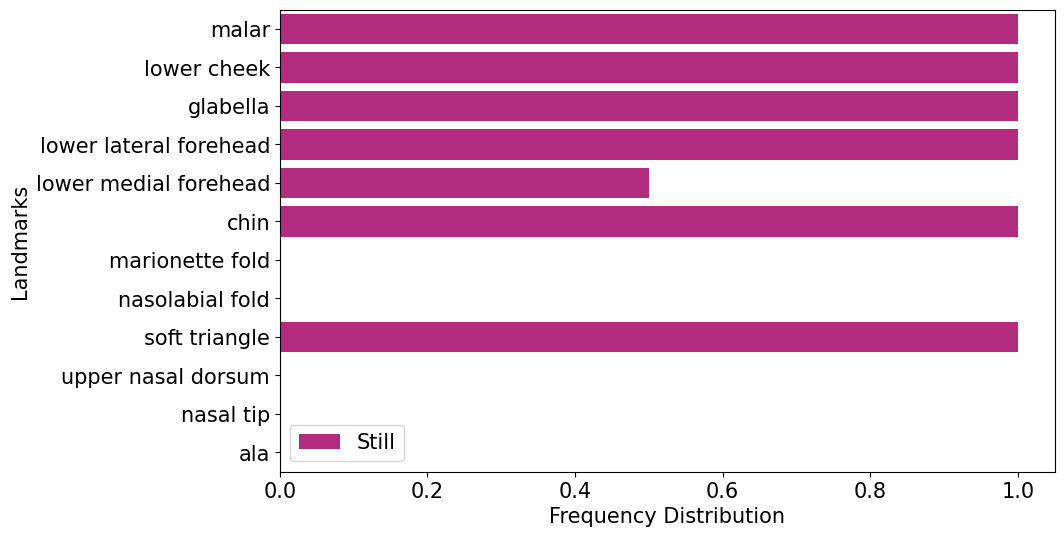

In [106]:
# Still mean MAE < 5
x = get_still(df).drop(columns=['video','person', 'MAE_z', 'PCC_z', 'timePCC_z', 'timeDTW_z', 'FreqScore','TimeScore', ]).copy()
x = x[x['landmarks_id'].isin(df_rank.query('bin == "G1: < 0.1%"').landmarks_id.unique())]
z, y1 = analyze_comb.eda_combination(x, sym_ldmks, agg_fct='mean', metric='score')

rois = z.ROI.unique().tolist()
t1 = analyze_comb.agg_ldmk_comb(y1, rois,case='comb_ldmk')

t1 = analyze_comb.agg_ldmk_comb(y1, sym_ldmks,case='ind_ldmk')
t1['setting'] = 'Still'
t_ldmk = analyze_comb.freq_ldmk_comb([t1], col='Landmarks', hue_col='setting', figsize=(10,6)) 

## Motion

In [55]:
x = df[(df['dataset'] == 'lgi_ppgi') & ~df['videoFilename'].str.contains('resting')].copy()

_, df_rank, ldmk_score_dict = analyze.get_df_rank(x.query('landmarks_len > 1'), bins=[0,0.1,0.9, 1])
df_rank = df_rank.sort_values('MAE_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

_, df_ind, _ = analyze.get_df_rank(x.query('landmarks_len == 1'), bins=[0,0.1,0.9, 1])
df_ind = df_ind.sort_values('MAE_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

Compare individual landmarks to combinations

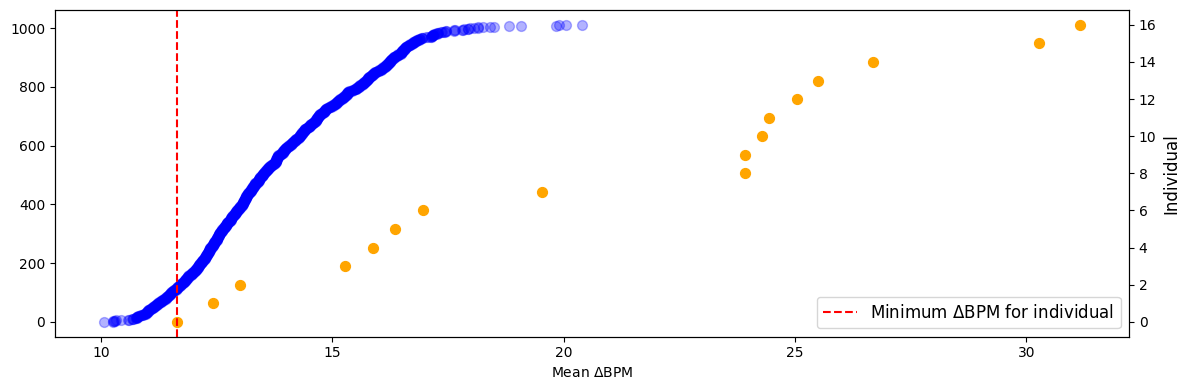

In [56]:
fig, ax1 = plt.subplots(1,1,figsize=(12,4), sharey=True)
ax2 = ax1.twinx()
df_rank = df_rank.sort_values('MAE_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

# plot the same data on both axes
ax1.scatter(y=df_rank['landmarks_id'], x=df_rank['MAE_mean'], s=50, c='blue', alpha=0.3, label='Combination of landmarks')
ax2.scatter(y=df_ind['landmarks_id'], x=df_ind['MAE_mean'], s=50, c='orange')
ax2.set_ylabel('Individual', fontsize=12)


ax2.axvline(df_ind['MAE_mean'].min(), color='red', linestyle='--', label=r'Minimum $\Delta$BPM for individual')
plt.legend(fontsize=12)
ax1.set_xlabel(r'Mean $\Delta$BPM')
fig.tight_layout()
plt.show()

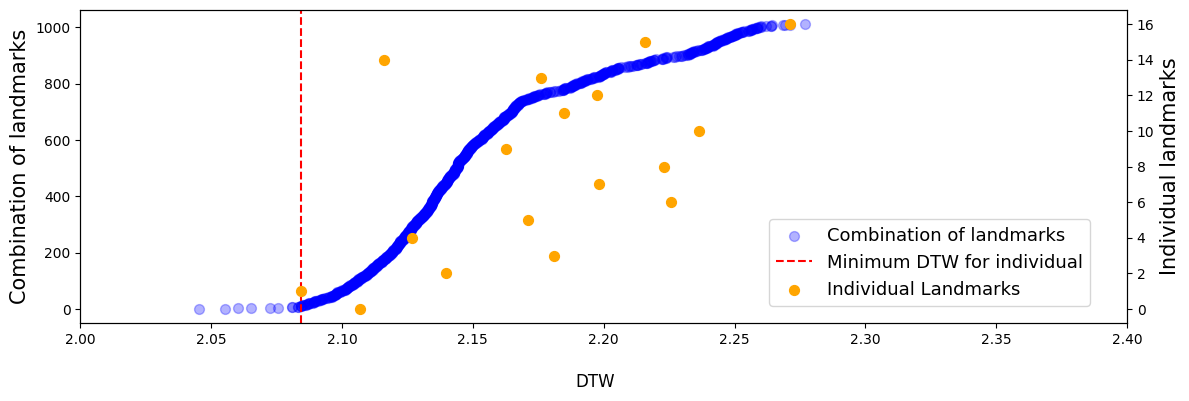

In [57]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(1,1,figsize=(12,4), sharey=True)
ax2 = ax1.twinx()
df_rank = df_rank.sort_values('DTW_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

# plot the same data on both axes
ax1.scatter(y=df_rank['landmarks_id'], x=df_rank['DTW_mean'], s=50, c='blue', alpha=0.3, label='Combination of landmarks')
ax2.scatter(y=df_ind['landmarks_id'], x=df_ind['DTW_mean'], s=50, c='orange', label='Individual Landmarks')
ax1.set_ylabel('Combination of landmarks', fontsize=15)
ax2.set_ylabel('Individual landmarks', fontsize=15)

ax1.set_xlim(2.0,2.4) 
ax2.set_xlim(2.0,2.4) 

ax1.axvline(df_ind['DTW_mean'].min(), color='red', linestyle='--', label=r'Minimum DTW for individual')
fig.legend(fontsize=13,bbox_to_anchor=[0.92, 0.2],loc='lower right')
fig.supxlabel(r'DTW')
fig.tight_layout()
plt.show()

Inspect top combinations

In [61]:
x = df[(df['dataset'] == 'lgi_ppgi') & ~df['videoFilename'].str.contains('resting')].copy()
_, df_rank_motion, ldmk_score_dict = analyze.get_df_rank(x.query('landmarks_len > 1'), bins=[0,0.1,0.9, 1])

df_ind = get_motion(df_ind_all)
_, df_ind, _ = analyze.get_df_rank(df_ind, bins=[0,0.1,0.9, 1])
df_ind = df_ind.sort_values('MAE_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

G1_motion = df_rank_motion.query(f'MAE_mean < {df_ind.MAE_mean.min()}').landmarks_id.unique()

print("Landmarks with MAE mean < individual: ",len(df_rank_motion.query(f'MAE_mean < {df_ind.MAE_mean.min()}')))
print("Landmarks with DTW mean < individual: ",len(df_rank_motion.query(f'DTW_mean < {df_ind.DTW_mean.min()}')))
print("Landmakrs in G1: ", len(G1_motion) )

df_rank_motion = df_rank_motion.sort_values('MAE_mean').drop(columns='landmarks_id').reset_index(drop=True).reset_index().rename({'index':'landmarks_id'}, axis=1)

Landmarks with MAE mean < individual:  117
Landmarks with DTW mean < individual:  10
Landmakrs in G1:  117


In [62]:
x = df[(df['dataset'] == 'lgi_ppgi') & ~df['videoFilename'].str.contains('resting')].copy()

# Mean MAE < 5
y = x.groupby(['landmarks_id', ])['MAE'].agg(['median','mean','std']).sort_values(by='mean', ascending=True).query('mean < 5').reset_index()
print("Number of combinations with mean MAE < 5: ", len(y.landmarks_id.unique()))

# G1: Mean MAE < best individual landmark
x_motion= x[x['landmarks_id'].isin(G1_motion)]

# From the combinations with mean MAE < 5, divide into bins wrt quantiles
x_all, df_rank, ldmk_OS_dict = analyze.get_df_rank(x_motion, bins=[0,0.1,0.9, 1])
df_top = df_rank.iloc[:10].copy()
df_top = df_top.merge(df[['landmarks_id', 'landmarks_names', 'landmarks_len']].drop_duplicates('landmarks_id'), on='landmarks_id', how='left')

display(df_top.head(1)) 

Number of combinations with mean MAE < 5:  0


,landmarks_id,landmarks,region,MAE_median,MAE_mean,MAE_std,OS_median,OS_mean,OS_std,DTW_median,DTW_mean,DTW_std,rank_MAE,rank_DTW,rank_OS,bin,landmarks_names,landmarks_len
0,604,"(glabella, left_malar, lower_medial_forehead, ...","C, F",8.952311,10.777167,8.872544,0.248937,0.251133,0.078018,2.108473,2.055441,0.198471,19,1,1,G2: 0.1-0.9%,"{lower medial forehead, glabella, malar}",3


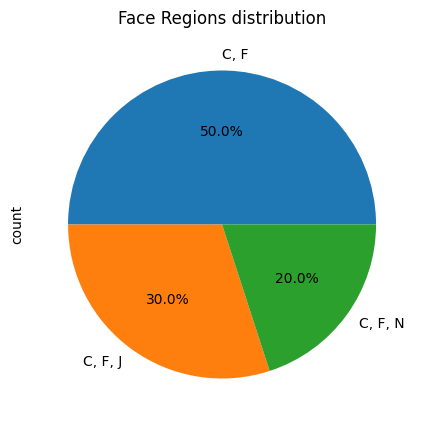

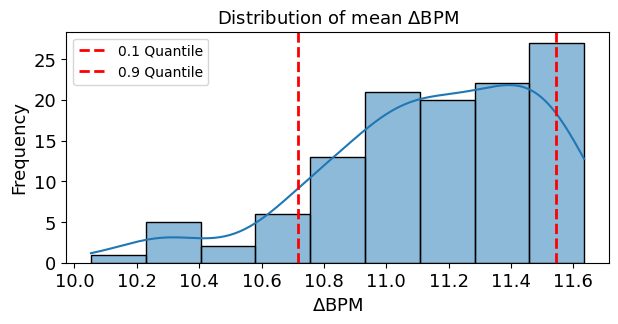

In [63]:
# EDA Plots 

fig, ax = plt.subplots(1,1, figsize=(5,5))
df_top['region'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
ax.set_title('Face Regions distribution')
plt.show()

# Create the histogram plot
quantiles = [0.1,0.9]
fig,ax = plt.subplots(1,1, figsize=(7, 3))
ax.tick_params(axis='both', which='major', labelsize=13)
sns.histplot(df_rank['MAE_mean'], kde=True, ax=ax, bins=9)
for quantile in quantiles:
    ax.axvline(df_rank['MAE_mean'].quantile(quantile), linestyle='dashed', color='red', linewidth=2, label=f'{quantile} Quantile')
ax.set_xlabel(r'$\Delta$BPM', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13)
ax.set_title(r'Distribution of mean $\Delta$BPM', fontsize=13)
ax.legend()


## Intersection

- Intersection of the best combinations in both still and motion : G1 = G1_still AND G1_motion

In [80]:
df['landmarks_names'] = df['landmarks_names'].apply(lambda x: ', '.join(map(str, sorted(x))).replace('_', ' '))

In [81]:
# Rank for still videos
x = get_still(df)
x = x[x['landmarks_id'].isin(G1_still) & x['landmarks_id'].isin(G1_motion)]
x_all, df_rank_still, ldmk_OS_dict = analyze.get_df_rank(x, bins=[0,0.1,0.9, 1])
df_top_still = df_rank_still.iloc[:10].copy()

df_top_still = df_top_still.merge(df[['landmarks_id', 'landmarks_names', 'landmarks_len']].drop_duplicates('landmarks_id'), on='landmarks_id', how='left')
df_rank_still = df_rank_still.merge(df[['landmarks_id', 'landmarks_names', 'landmarks_len']].drop_duplicates('landmarks_id'), on='landmarks_id', how='left')

display(df_top_still.head(3)) 

,landmarks_id,landmarks,region,MAE_median,MAE_mean,MAE_std,OS_median,OS_mean,OS_std,DTW_median,DTW_mean,DTW_std,rank_MAE,rank_DTW,rank_OS,bin,landmarks_names,landmarks_len
0,39,"(chin, glabella, left_lower_cheek, left_lower_...","C, F, J",2.824198,4.683231,4.841239,0.161660,0.173225,0.083673,1.814847,1.838668,0.360804,5,4,1,G2: 0.1-0.9%,"chin, glabella, lower cheek, lower lateral for...",5
1,483,"(glabella, left_lower_cheek, left_lower_latera...","C, F",2.540461,4.912352,5.366401,0.154220,0.173885,0.089090,1.744630,1.834571,0.368541,25,1,2,G2: 0.1-0.9%,"glabella, lower cheek, lower lateral forehead,...",4
2,559,"(glabella, left_lower_lateral_forehead, left_m...","C, F, N",2.020194,4.862676,5.734739,0.153721,0.174204,0.086837,1.788943,1.837957,0.340547,20,3,3,G2: 0.1-0.9%,"glabella, lower lateral forehead, malar, upper...",4


In [82]:
# Rank for motion videos
x = df[(df['dataset'] == 'lgi_ppgi') & ~df['videoFilename'].str.contains('resting')].copy()
x = x[x['landmarks_id'].isin(G1_motion) & x['landmarks_id'].isin(G1_motion)]
x_all, df_rank_motion, ldmk_OS_dict = analyze.get_df_rank(x, bins=[0,0.1,0.9, 1])
df_top_motion = df_rank_motion.iloc[:10].copy()

df_top_motion = df_top_motion.merge(df[['landmarks_id', 'landmarks_names', 'landmarks_len']].drop_duplicates('landmarks_id'), on='landmarks_id', how='left')
df_rank_motion = df_rank_motion.merge(df[['landmarks_id', 'landmarks_names', 'landmarks_len']].drop_duplicates('landmarks_id'), on='landmarks_id', how='left')

display(df_top_motion.head(3)) 

,landmarks_id,landmarks,region,MAE_median,MAE_mean,MAE_std,OS_median,OS_mean,OS_std,DTW_median,DTW_mean,DTW_std,rank_MAE,rank_DTW,rank_OS,bin,landmarks_names,landmarks_len
0,604,"(glabella, left_malar, lower_medial_forehead, ...","C, F",8.952311,10.777167,8.872544,0.248937,0.251133,0.078018,2.108473,2.055441,0.198471,19,1,1,G2: 0.1-0.9%,"glabella, lower medial forehead, malar",3
1,590,"(glabella, left_malar, left_marionette_fold, l...","C, F, J",7.154887,10.257019,7.513890,0.245712,0.257275,0.069424,2.159800,2.105978,0.195910,2,17,2,G1: < 0.1%,"glabella, lower medial forehead, malar, marion...",4
2,553,"(glabella, left_lower_lateral_forehead, left_m...","C, F",8.993856,10.776485,8.858337,0.242977,0.257489,0.081233,2.152924,2.089769,0.210209,18,5,3,G2: 0.1-0.9%,"glabella, lower lateral forehead, lower medial...",4


In [83]:
df_G1 = df_top_motion[['landmarks_id', 'landmarks', 'region', 'landmarks_names', 'landmarks_len', 'MAE_mean', 'DTW_mean', 'rank_OS']].merge(
    df_top_still[['landmarks_id', 'MAE_mean', 'DTW_mean', 'rank_OS']],
    on=['landmarks_id'], suffixes=('_motion', '_still'), how='inner').sort_values(by=['rank_OS_still'])
df_G1['rank_mean'] = (df_G1['rank_OS_still'] + df_G1['rank_OS_motion']) / 2
df_G1 = df_G1.sort_values(['rank_mean', 'rank_OS_still', 'rank_OS_motion'])

df_G1.head()

,landmarks_id,landmarks,region,landmarks_names,landmarks_len,MAE_mean_motion,DTW_mean_motion,rank_OS_motion,MAE_mean_still,DTW_mean_still,rank_OS_still,rank_mean
0,553,"(glabella, left_lower_lateral_forehead, left_m...","C, F","glabella, lower lateral forehead, lower medial...",4,10.776485,2.089769,3,4.93241,1.842787,10,6.5


In [85]:
df_G1 = df_rank_motion[['landmarks_id', 'landmarks', 'region', 'landmarks_names', 'landmarks_len', 'MAE_mean', 'DTW_mean', 'rank_OS']].merge(
    df_rank_still[['landmarks_id', 'MAE_mean', 'DTW_mean', 'rank_OS']],
    on=['landmarks_id'], suffixes=('_motion', '_still'), how='inner'
)
df_G1['rank_mean'] = (df_G1['rank_OS_still'] + df_G1['rank_OS_motion']) / 2
df_G1 = df_G1.sort_values(['rank_mean', 'rank_OS_still', 'rank_OS_motion']).reset_index(drop=True)

df_G1.head()

,landmarks_id,landmarks,region,landmarks_names,landmarks_len,MAE_mean_motion,DTW_mean_motion,rank_OS_motion,MAE_mean_still,DTW_mean_still,rank_OS_still,rank_mean
0,553,"(glabella, left_lower_lateral_forehead, left_m...","C, F","glabella, lower lateral forehead, lower medial...",4,10.776485,2.089769,3,4.932410,1.842787,10,6.5
1,606,"(glabella, left_malar, lower_medial_forehead, ...","C, F, N","glabella, lower medial forehead, malar, soft t...",5,11.611111,2.091571,18,4.876240,1.838746,5,11.5
2,604,"(glabella, left_malar, lower_medial_forehead, ...","C, F","glabella, lower medial forehead, malar",3,10.777167,2.055441,1,4.886630,1.853841,23,12.0
3,226,"(chin, left_lower_cheek, left_lower_lateral_fo...","C, F, J","chin, lower cheek, lower lateral forehead, low...",5,11.122552,2.097650,10,4.862405,1.848479,15,12.5
4,483,"(glabella, left_lower_cheek, left_lower_latera...","C, F","glabella, lower cheek, lower lateral forehead,...",4,10.883184,2.121510,24,4.912352,1.834571,2,13.0


In [87]:
df_G1.query('landmarks_names == "glabella, malar"')

,landmarks_id,landmarks,region,landmarks_names,landmarks_len,MAE_mean_motion,DTW_mean_motion,rank_OS_motion,MAE_mean_still,DTW_mean_still,rank_OS_still,rank_mean
18,608,"(glabella, left_malar, right_malar)","C, F","glabella, malar",2,11.28956,2.131358,65,4.691326,1.870345,25,45.0
